In [38]:
import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
A = np.random.rand(3,4)
# print(np.matmul(np.array(,range(4)),np.ones_like(A[0,:])))
Amean = np.mean(A,0)
A_mc = np.array([Acol - Amean for Acol in A])
print(np.mean(A_mc,0))

[ -3.70074342e-17   7.40148683e-17   7.40148683e-17   1.11022302e-16]


In [35]:
def test_fun(x):
    return 2*x

f = test_fun
f(2)

4

[-0.4126917  -0.3183572   0.05503904] 
Pxy:
 [[  0.00000000e+00]
 [  7.42610007e-03]
 [  1.92592994e-34]] 
Pyy:
 [[ 0.0148522]]
X: (3, 6) K: (3, 1) noisy_data: (1,) Y: (1, 6)
xhat:
 [-0.4126917  -0.52714914  0.05503904]
Xa:
 [[-0.20055967 -0.4126917  -0.4126917  -0.62482373 -0.4126917  -0.4126917 ]
 [-0.3183572  -0.16909802 -0.3183572  -0.3183572  -0.46761637 -0.3183572 ]
 [ 0.05503904  0.05503904  0.20429821  0.05503904  0.05503904 -0.09422014]]
[-0.4126917  -0.52714914  0.05503904] 
Pxy:
 [[  0.00000000e+00]
 [  3.71305003e-03]
 [ -3.85185989e-34]] 
Pyy:
 [[ 0.01113915]]
X: (3, 6) K: (3, 1) noisy_data: (1,) Y: (1, 6)
xhat:
 [-0.4126917  -0.7697154   0.05503904]
Xa:
 [[-0.20055967 -0.4126917  -0.4126917  -0.62482373 -0.4126917  -0.4126917 ]
 [-0.52714914 -0.42160697 -0.52714914 -0.52714914 -0.63269131 -0.52714914]
 [ 0.05503904  0.05503904  0.20429821  0.05503904  0.05503904 -0.09422014]]
[-0.4126917  -0.7697154   0.05503904] 
Pxy:
 [[ 0.        ]
 [ 0.00247537]
 [ 0.        ]] 
Pyy:


/Users/emilyschlafly/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/emilyschlafly/anaconda/envs/py3k/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


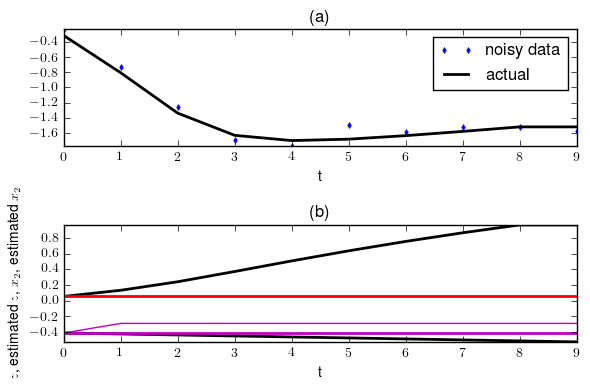

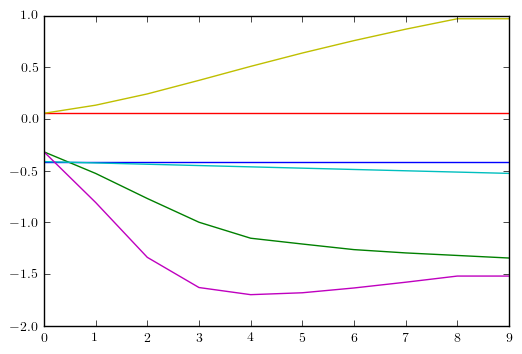

In [433]:
# voss.m function translated from schiff, ch5, p.110
dims_params = 1 # dq
dims_augmented_state, dims_observations = dims_params+2, 1 # dx, dy
fct = vossFNfct
obsfct = vossFNobsfct
num_samples = 10
dt_sample = 0.2
dt_integrate = dt_sample
steps_per_sample = int(dt_sample//dt_integrate)

# Preallocate arrays
x0 = np.zeros((2,num_samples)) # true trajectory
xhat = np.zeros((dims_augmented_state,num_samples)) # estimated trajectory
Pxx = np.zeros((dims_augmented_state,dims_augmented_state,num_samples)) # covariance in x
errors = np.zeros((dims_augmented_state, num_samples))
Ks = np.zeros((dims_augmented_state,dims_observations,num_samples))

# Initial conditions
x0[:,0] = [0.,0.]

# External input current, estimated as parameter p later
Iext = np.arange(1,num_samples+1)/250.*2*np.pi
Iext = -0.4 - 1.01*(np.abs(np.sin(Iext/2.)))
# plt.plot(Iext)
# plt.show()

# RuKu4 integrator
def ruku4(num_samples,x0,dt_integrate,Iext):
    for n in range(num_samples-1):
        x_temp = x0[:,n]
        for i in range(steps_per_sample):
            k1 = dt_integrate*vossFNint(x_temp,Iext[n])
            k2 = dt_integrate*vossFNint(x_temp+k1/2,Iext[n])
            k3 = dt_integrate*vossFNint(x_temp+k2/2,Iext[n])
            k4 = dt_integrate*vossFNint(x_temp+k3,Iext[n])
#             print('x_temp:',x_temp,'k1:',k1,'k2:',k2)
            x_temp += k1/6. + k2/3. + k3/3. + k4/6.
        x0[:,n+1] = x_temp
    return x0

x0 = ruku4(num_samples,x0,dt_integrate,Iext)
    
augmented_state = np.vstack((Iext,x0))
xhat[:,0] = augmented_state[:,0]

# Covariances
process_noise = 0.015
observation_noise = 0.2*0.2*np.var(vossFNobsfct(augmented_state))*np.eye(dims_observations)

noisy_data = obsfct(augmented_state) + np.matmul(la.sqrtm(observation_noise),
                                   np.random.randn(dims_observations,num_samples))
Pxx[:,:,0] = la.block_diag(process_noise,observation_noise,observation_noise)

# Main loop for recursive estimation
for k in range(1,num_samples):
    xhat[:,k],Pxx[:,:,k],Ks[:,:,k] = voss_unscented_transform(xhat[:,k-1],Pxx[:,:,k-1],noisy_data[:,k],
                                         fct,obsfct,dims_params,dims_augmented_state,
                                         dims_observations, observation_noise)
    Pxx[0,0,k] = process_noise
    errors[:,k] = np.sqrt(np.diag(Pxx[:,:,k]))
    
# Results
chisq = np.mean((augmented_state[0,:]-xhat[0,:])**2 + (augmented_state[1,:]-xhat[1,:])**2 + 
               (augmented_state[2,:] - xhat[2,:])**2) # this can probably be simplified to mean((augmented_state - xhat)**2)
est = np.transpose(xhat[0:dims_params-1,-1])
error = np.transpose(errors[0:dims_params-1,-1])
meanest = np.mean(np.transpose(xhat[:dims_params-1,:]))
meanerror = np.mean(np.transpose(errors[:dims_params,:]))

# Plotting
plt.rc('text', usetex=True)
plt.subplot(2,1,1)
plt.plot(noisy_data[0,:],'bd',markeredgecolor='blue', mfc='blue',ms=3,label='noisy data');
plt.plot(augmented_state[dims_params,:],'k',linewidth=2,label='actual'); 
plt.xlabel('t');
plt.legend();
plt.axis('tight')
plt.title('(a)')
plt.subplot(2,1,2)
plt.plot(augmented_state[dims_params+1,:],'k',lw=2,label='decay variable');
plt.plot(xhat[dims_params+1,:],'r',lw=2); 
plt.plot(augmented_state[0,:],'k',lw=2, label='external current');
for i in range(dims_params):
    plt.plot(xhat[i,:],'m',linewidth=2)
    plt.plot(xhat[i,:] + errors[i,:],'m')
plt.xlabel('t')
plt.ylabel('$z$, estimated $z$, $x_2$, estimated $x_2$')
plt.axis('tight')
plt.title('(b)')
plt.tight_layout()
plt.figure()
plt.plot(xhat.T)
plt.plot(augmented_state.T)
plt.show()

In [432]:
# vossut function translated from matlab code in Schiff, ch 5, p.110

def voss_unscented_transform(xhat,Pxx,noisy_data,fct,obsfct,dims_params,dims_augmented_state,
           dims_observations,observation_noise):
    
    Pxx = symmetrize(Pxx)
    
    Xa = generate_sigma_points(xhat,Pxx)
    X = fct(dims_params,Xa)
    Y = obsfct(X).reshape(1,-1)
    
    Pxx = symmetrize(covariance(X,X))
    Pyy = covariance(Y,Y) + observation_noise
    Pxy = covariance(X,Y)
        
    K = np.matmul(Pxy,la.inv(Pyy))
    xhat = np.mean(X,1) + np.matmul(K,(noisy_data - np.mean(Y,1)))
#     
    print(np.mean(X,1), '\nPxy:\n', Pxy, '\nPyy:\n',Pyy)
#     print(np.mean(X,1), np.matmul(K,(noisy_data - np.mean(Y,1))))
    print('X:', X.shape, 'K:', K.shape, 'noisy_data:',noisy_data.shape, 'Y:', Y.shape)
#     
    print('xhat:\n', xhat)
    print('Xa:\n', Xa)
#     
    Pxx = symmetrize(Pxx - np.matmul(K,Pxy.T))
    
    return xhat,Pxx,K

def covariance(X,Y):
    '''Calculates biased covariance (or cross covariance) of array-like X and Y'''
    num_samples = len(X[0,:])
    X_centered = mean_center(np.array(X))
    Y_centered = mean_center(np.array(Y))
    return np.matmul(X_centered,Y_centered.T/num_samples)

def mean_center(X):
    '''Centers the mean of rows of X (array-like) around 0.'''
    return np.array([x - np.mean(x) for x in X])

def symmetrize(A):
    '''Numerical safety'''
    return (A + np.transpose(A)) / 2

def generate_sigma_points(xhat,Pxx):
    '''Why have the extra terms from the Cholesky decomp?? Why not just use sigma in each direction?'''
    dims = len(xhat)
    num_sigma_points = 2*dims
    Pxx = symmetrize(Pxx)
    xsigma = la.cholesky(dims*Pxx)
#     print('xsigma:\n',xsigma[:,:10])
#     print('xsigma:', xsigma, 'xhat:',np.array(xhat))
#     for row in xsigma:
#         print('xsigma_row:',row)
    Xa = np.hstack((xsigma,-xsigma))
#     print('Xa:\n',Xa[:,:10])
    for i in range(num_sigma_points):
        Xa[:,i]+=xhat
#     print('Xa:', Xa)
    return Xa
# np.array([xhat + xsigma_row for xsigma_row in np.vstack((xsigma,-xsigma))])


In [380]:
# Test: mean_center 
A = np.random.randn(3,4)
A0 = mean_center(A)
assert np.allclose(np.mean(A0,1),0)

# Test: symmetrize
A = np.random.randn(3,3)
assert (symmetrize(A) == np.transpose(symmetrize(A))).all()

# Test: covariance
A = np.array(np.random.randn(2,10))
B = np.array(np.random.randn(1,10))
assert np.allclose(covariance(A,A),np.cov(A,bias=True))
print(covariance(A,B))
# assert np.allclose(covariance(A,B),np.cov(A,B,bias=True))

# Test: generate_sigma_points


[[ 0.33465407]
 [ 0.01930409]]


In [254]:
# A = np.random.randn(2,30)
A = 2*np.ones((2,6))
A[:,0::2] = 0.
print(A)
Pxx = covariance(A,A)
print(Pxx)
xhat = np.array([[1.], [1.]])
print('sigma points:\n',generate_sigma_points(xhat[:,0],Pxx))

[[ 0.  2.  0.  2.  0.  2.]
 [ 0.  2.  0.  2.  0.  2.]]
[[ 1.  1.]
 [ 1.  1.]]
sigma points:
 [[ 2.41421356  2.41421356 -0.41421356 -0.41421356]
 [ 1.          1.00000002  1.          0.99999998]]


In [431]:
def vossFNint(state,input_current):
    '''Check this... Returns derivative of voltage (state[0]) and recovery (state[1]) variables'''
    a, b, c = 0.7, 0.8, 3.
    return np.array([c*(state[1]+state[0]-state[0]**3/3+input_current),
                     -(state[0]-a+b*state[1])/c]);

def vossFNobsfct(state):
    return state[1,:].reshape(1,len(state[1,:]))

def vossFNfct(dims_params, augmented_state):
    Iext = augmented_state[:dims_params,:]
    observations = augmented_state[dims_params:,:]
    observations = ruku4(1,observations,dt_integrate,Iext)
    return np.vstack((Iext,observations))
    